In [1]:
!pip install nltk
!pip install twython
!pip install textblob
!pip install wordcloud

In [2]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [3]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [4]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
df = pd.read_csv("reviews_data.csv")

In [7]:
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.00,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.00,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.00,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.00,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.00,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [8]:
df.Rating.value_counts()

,count
Rating,
1.00,451
2.00,99
5.00,83
4.00,39
3.00,33


In [9]:
df.Review[1]

'** at the Starbucks by the fire station on 436 in Altamonte Springs, FL made my day and finally helped me figure out the way to make my drink so I’d love it. She took time out to talk to me for 2 minutes to make my experience better than what I’m used to. It was much appreciated! I’ve had bad experiences one after another at the Starbucks that’s closest to me in my work building with my drinks not being great along with not great customer service from specific baristas. Niko was refreshing to speak to and pleasant. The drink was perfect! Store 11956'

In [10]:
df.Review[5]

'We had to correct them on our order 3 times. They never got it right then the manager came over to us and said we made her employee uncomfortable because we were trying to correct our order. The manager tried was racist against my stepmom (Chinese) taking over her but when I (**) would talk she would stop talking and listen to me.'

In [11]:
df.Review[10]

"I filed a BBB complaint last month because Starbucks canceled my Starbucks Reward cards. I couldn't remember the balances, so I guessed about $9. Starbucks played nothing but games and tried everything they could to avoid responding to the complaint. I received a couple of phone call messages asking me to contact them directly and discuss the matter. The number provided was the customer service number and when I spoke with one representative, Linda hung up the phone on me. I did not use my card since 2012 which is my prerogative. Because of this and other reasons, Starbucks decided to close my Starbucks account. I reopened one about a few weeks ago and added a new card that I have not used yet."

In [12]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.7 MB/s eta 0:00:00


In [13]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from contractions import fix
from textblob import TextBlob
from collections import Counter

In [51]:
# Pre-calculate stopwords
stop_words = set(stopwords.words('english'))

def preprocess_review(text, rare_words):
    # 1️⃣ Lowercase
    text = text.lower()

    # 2️⃣ Expand contractions
    text = fix(text)

    # 3️⃣ Remove unwanted characters but keep sentence enders: . ? !
    text = re.sub(r"[^a-zA-Z\s\.\?\!]", "", text)

    # 4️⃣ Tokenize (preserve punctuation as separate tokens)
    words = word_tokenize(text)

    # 5️⃣ Spelling correction (ignore punctuation tokens)
    words = [str(TextBlob(word).correct()) if word.isalpha() else word for word in words]

    # 6️⃣ Remove stopwords (only for actual words)
    words = [word for word in words if word.lower() not in stop_words or word in ['.', '?', '!']]

    # 7️⃣ Lemmatization (only for words, not punctuation)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) if word.isalpha() else word for word in words]

    # 8️⃣ Reconstruct sentence preserving punctuation spacing
    cleaned_text = " ".join(words)
    # Fix spacing before punctuation
    cleaned_text = re.sub(r'\s+([\.!?])', r'\1', cleaned_text)

    return cleaned_text


In [52]:
df["Review"] = df["Review"].apply(lambda x: preprocess_review(x, rare_words=None))

In [53]:
df["Review"][1]

'starbucks fire station altamonte spring made day finally helped figure way make drink would love. took time talk minute make experience better used. much appreciated! bad experience one another starbucks closest work building drink great along great customer service specific baristas. refreshing speak pleasant. drink perfect! store'

In [54]:
df["Review"][5]

'correct order time. never got right manager came u said made employee uncomfortable trying correct order. manager tried racism stepmom chinese taking would talk would stop talking listen.'

In [55]:
df["Review"][10]

'filed bob complaint last month starbucks canceled starbucks reward card. could remember balance guessed. starbucks played nothing game tried everything could avoid responding complaint. received couple phone call message asking contact directly discus matter. number provided customer service number spoke one representative mind hung phone. use card since prerogative. reason starbucks decided close starbucks account. reopened one week ago added new card used yet.'

In [56]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [57]:
tf.columns = ['words','tf']

In [58]:
tf_sorted = tf.sort_values(by='tf',ascending=False)

In [59]:
tf_sorted.head()

,words,tf
2,starbucks,934.00
129,coffee,499.00
12,customer,358.00
24,drink,278.00
39,time,273.00


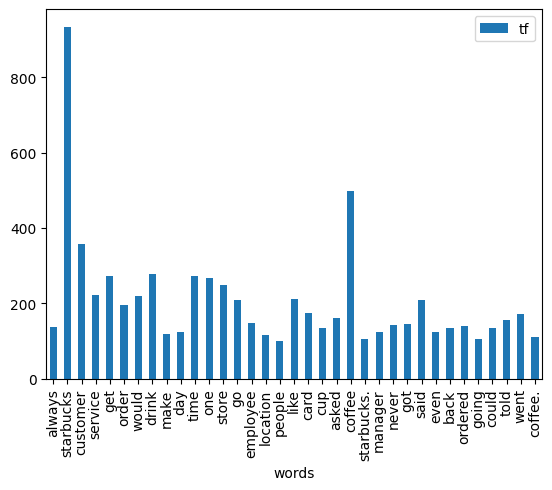

In [60]:
tf[tf["tf"] > 100].plot.bar(x="words", y="tf")
plt.show(block=True)

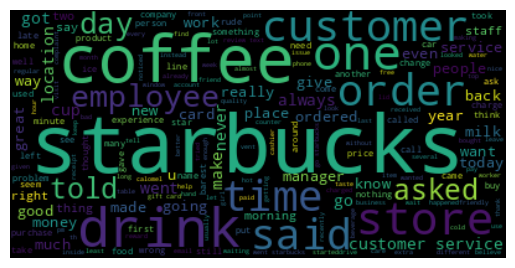

In [61]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [62]:
sia = SentimentIntensityAnalyzer()

In [63]:
df["polarity_score"] = df['Review'].apply(lambda x: sia.polarity_scores(x)["compound"])

In [64]:
df.head()

,name,location,Date,Rating,Review,Image_Links,polarity_score
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.00,amber madonna starbucks southwest parkman alwa...,['No Images'],0.88
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.00,starbucks fire station altamonte spring made d...,['No Images'],0.97
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.00,wanted go way recognize starbucks employee bil...,['https://media.consumeraffairs.com/files/cach...,0.52
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.00,friend starbucks card work. thankful worker pa...,['No Images'],0.97
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.00,kick drinking cup warm water. work instacart r...,['https://media.consumeraffairs.com/files/cach...,0.97


In [65]:
df['Sentiment_Label'] = df['Review'].apply(lambda x:'pos' if sia.polarity_scores(x)['compound']>0 else 'neg')

In [66]:
df.head()

,name,location,Date,Rating,Review,Image_Links,polarity_score,Sentiment_Label
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.00,amber madonna starbucks southwest parkman alwa...,['No Images'],0.88,pos
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.00,starbucks fire station altamonte spring made d...,['No Images'],0.97,pos
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.00,wanted go way recognize starbucks employee bil...,['https://media.consumeraffairs.com/files/cach...,0.52,pos
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.00,friend starbucks card work. thankful worker pa...,['No Images'],0.97,pos
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.00,kick drinking cup warm water. work instacart r...,['https://media.consumeraffairs.com/files/cach...,0.97,pos


In [67]:
df.groupby("Sentiment_Label")["Rating"].mean()

,Rating
Sentiment_Label,
neg,1.36
pos,2.20


In [68]:
X_train,X_test,y_train,y_test = train_test_split(df['Review'],df['Sentiment_Label'],test_size=0.2,random_state=42)

In [69]:
# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

In [70]:
# TF-IDF N-Gram Level (2,2)
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 2)).fit(X_train)
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_train)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test)

In [71]:
# Modelling(Logistic Regression - word level)
log_model_word = LogisticRegression().fit(x_train_tf_idf_word, y_train)
y_pred_word = log_model_word.predict(x_test_tf_idf_word)

print(classification_report(y_pred_word, y_test))

              precision    recall  f1-score   support

         neg       0.33      0.83      0.48        29
         pos       0.95      0.66      0.78       141

    accuracy                           0.69       170
   macro avg       0.64      0.74      0.63       170
weighted avg       0.84      0.69      0.73       170



In [72]:
cross_val_score(log_model_word, x_test_tf_idf_word, y_test, cv=5).mean()

np.float64(0.6294117647058823)

In [73]:
# Randomly selecting comments from the data and asking them to the model
random_review = pd.Series(df["Review"].sample(1).values)
new_comment = CountVectorizer().fit(X_train).transform(random_review)
pred = log_model_word.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  starbucks road ann harbor michigan. filthy... overflowing trash... outdoor inside. rude disrespectful staff acknowledge customer. never smile explanation process. covertly rude. endemic. several time past year. time give benefit doubt.. never!!!! despicable behavior toward paying customer always tapped plus percent rate. 
 Prediction: ['neg']


In [74]:
# Modelling(Logistic Regression - ngram level)
log_model_ngram = LogisticRegression().fit(x_train_tf_idf_ngram, y_train)
y_pred_ngram = log_model_ngram.predict(x_test_tf_idf_ngram)

print(classification_report(y_pred_ngram, y_test))

              precision    recall  f1-score   support

         neg       0.11      1.00      0.20         8
         pos       1.00      0.60      0.75       162

    accuracy                           0.62       170
   macro avg       0.56      0.80      0.48       170
weighted avg       0.96      0.62      0.73       170



In [75]:
cross_val_score(log_model_ngram, x_test_tf_idf_ngram, y_test, cv=5).mean()

np.float64(0.6235294117647059)

In [76]:
# Randomly selecting comments from the data and asking them to the model
random_review = pd.Series(df["Review"].sample(1).values)
new_comment = tf_idf_ngram_vectorizer.transform(random_review)
pred = log_model_ngram.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  tried reading starbucks card using mobile pp go. error nothing. keep pointing back login information. tried couple time still unsuccessful. tried use different card still. point decided give let barest load card. went problem. got home checked online account found charged time. called starbucks agent told known issue release hold day. contracted credit card company find release hold faster. need starbucks representative call. 
 Prediction: ['neg']


In [77]:
# Modelling (Random Forest)
rf_model_word = RandomForestClassifier().fit(x_train_tf_idf_word, y_train)
print(classification_report(y_pred_word, y_test))

              precision    recall  f1-score   support

         neg       0.33      0.83      0.48        29
         pos       0.95      0.66      0.78       141

    accuracy                           0.69       170
   macro avg       0.64      0.74      0.63       170
weighted avg       0.84      0.69      0.73       170



In [78]:
cross_val_score(rf_model_word, x_test_tf_idf_word, y_test, cv=5, n_jobs=-1).mean()

np.float64(0.6176470588235294)

In [79]:
rf_model_ngram = RandomForestClassifier().fit(x_train_tf_idf_ngram, y_train)
y_pred_ngram = rf_model_ngram.predict(x_test_tf_idf_ngram)
print(classification_report(y_test, y_pred_ngram))

              precision    recall  f1-score   support

         neg       0.82      0.12      0.22        72
         pos       0.60      0.98      0.75        98

    accuracy                           0.62       170
   macro avg       0.71      0.55      0.48       170
weighted avg       0.69      0.62      0.52       170



In [80]:
cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, y_test, cv=5, n_jobs=-1).mean()

np.float64(0.4705882352941176)